# Finding Metro Best Route

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
import pandas as pd
from random import *
import numpy as np


### The goal of this project is to find an optimal route of the Paris metro stations following the rules: 
-	 The route must include all intramural stations ;
-	 The path might include non-intramural stations;
-	 Total time may not exceed 20 hours;

In [ ]:
#Stations (our nodes or vertices in graph theory)
ver = pd.read_csv("nodes.csv") 
ver.columns = ['id','Station','lat','lon'] 
ver.head()

In [3]:
#Edges (connections among stations)
edg = pd.read_csv("edges.csv") 
edg.columns = ['n1','n2','time']
edg.head()

### The problem is well suited to be solved with graph theory. In python a package called *networkx* has built-in functions for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

In [4]:
def graph_def():
    # Create empty graph
    g = nx.DiGraph()

    # Add edges and edge attributes
    for i, elrow in edg.iterrows():
        g.add_edge(elrow[0], elrow[1],weight= 1000/elrow[2], **elrow[2:].to_dict())
    return g

In [5]:
#function to update the edge's weigths whose nodes were already covereddef weight_update(x,y): 
    return g.add_edge(x, y, weight=g[x][y]['weight']*1/2)

In [6]:
#The funcion k_shortest_paths returns k paths based in the built-in function shortest_simple_paths avaliable on networkx
def k_shortest_paths(G, source, target, k, weight):  
    return list(islice(nx.shortest_simple_paths(G, source, target, weight=None), k))   

In [7]:
#this function returns the best path based on the quantity of non-visited stations. 
#it helps the function next_node in the decision process
def best_path(path): 
    maxsize = 0
    #time = calc_time(path)
    for p in path:
        size = 0
        for x in p:
            size = size + len(stop[(stop[['id']] == x).any(axis=1)]) 
            
            if size > maxsize:
                maxsize = size
                bestpath = p        
    return (bestpath, maxsize/len(bestpath))

In [8]:
def calc_time(path,s,d):
    k = 0 
    sum_t = 0 
    temp1 = 0   
    
    for p in path:
        if (k < (len(path)-1)):
            a1 = path[k]
            a2 = path[k+1]
            temp1 = int(pd.DataFrame(edg[(edg.n1 == a1) & (edg.n2 == a2)]['time']).iloc[0])
            sum_t = sum_t + temp1            
            k = k+1     
    #print('sumt_t dentro do calc_time: '+str(sum_t))
    return sum_t

In [9]:
#decision for what will be the next node
#this function is "the heart" of the algorithm. it decides what is going to be the next destination point
def next_node(G, n):
    
    #initializing some variables
    sinal = 0
    tmin = 1000000
    max_weight = -1
    sum_t = 0
    neighbors = list(nx.neighbors(G, n)) 
    max_score = 0
    next_node = int(pd.DataFrame(stop['id'].sample(n=1)).iloc[0]) 
    
    #checking if there are any non-visited station in the neighborhood

    for node in neighbors:
        if not (stop[(stop[['id']] == node).any(axis=1)].empty):    #if there is a non-visited neighbor
            if (G[n][node]['weight'] > max_weight):     #checking which is the best neighbor based on the weights 
                max_weight = G[n][node]['weight'] 
                next_node = node
            sinal = 1
    #there isn't  any non-visited station in the neighborhood (sinal = 0)
    if (sinal == 0):
        for i in range(len(stop)):  #generating possible destinations 
            sum_t = 0
            dest = int(pd.DataFrame(stop['id'].sample(n=1)).iloc[0])   
            pathn = k_shortest_paths(g, n, dest, 1 , weight='weight')  #generating paths
            trajn,score = best_path(pathn)   #checking the score the path
            t = calc_time(pathn,int(n),int(dest))
            if t > tmin:  
                score = score*0.9  #penalizing the score in the case of t > tmin
                tmin = t
            if (score > max_score):   #checking if the score is better than the other paths previosily analysed 
                next_node = dest
                max_score = score
                           
        
    return (int(next_node), sinal) 

In [10]:
#Loading the intramural stations
stop = pd.read_csv("C:/Users/taisa/OneDrive/DSTI/Metaheuristics/exam/stops.csv") 
stop.columns = ['id','name']
ids = stop['id']

### Looping over different start points (each intramural station is a possible start point) and finding the one with the shortest time:

In [19]:
total = 100000
temporario = []
pt1 = []
pt2 = []

for ite in ids:
    #stop = list of stations one must visit
    stop = pd.read_csv("C:/Users/taisa/OneDrive/DSTI/Metaheuristics/exam/stops.csv") 
    stop.columns = ['id','name'] 
    # print('Stations one must visit: ' + str(len(stop))) 

    #defining the graph - back to the original graph after using a different starting station 
    g = graph_def()
    
    #initializing the variables
    s = ite
    s0 = s    
    d,sinalizador = next_node(g, s) #int(pd.DataFrame(stop['id'].sample(n=1)).iloc[0]) 
    d0 = d
    p1 = []
    p2 = []
    i = 0
    sum_t = 0


    while not stop.empty:
      #  print('********************************')   
      #  print('From station ' + str(s)+ ' to station ' + str(d))

        if sinalizador == 0:
            path = k_shortest_paths(g, s, d,10, weight=None)
            traj,score = best_path(path)
        else: 
            traj = list(islice(nx.shortest_simple_paths(g, s, d, weight=None),1))

        #print(traj)
        #if (sinalizador == 0): print('From: ' + str(s) +' to ' + str(d) + ' | t = ' + str(calc_time(traj,s,d)) + 's')



        k = 0   
        for t in traj:
            #for paths with more than 1 edge
            if k < (len(traj)-1) and (sinalizador == 0):
                a1 = traj[k]
                a2 = traj[k+1]

           
                nome_a1 = pd.DataFrame(ver[(ver.id == a1)]['Station']).iloc[0]
                nome_a2 = pd.DataFrame(ver[(ver.id == a2)]['Station']).iloc[0]
                #Some of the stations have more than one id assigned to it. 
                #This is the case of large stations like Chatelet, where 5 metro lines are passing by 
                #(consequently Chatelet has 5 sations id)
                # In this case, instead of using the station id, the algorithm deletes all the rows 
                # based on the name Chatelet from the non-visited stations list. 
                
                stop = stop[~(stop[['name']] == nome_a1[0]).any(axis=1)]  
                stop = stop[~(stop[['name']] == nome_a2[0]).any(axis=1)]  
                
                stop = stop[~(stop[['id']] == a2).any(axis=1)]  
                stop = stop[~(stop[['id']] == a1).any(axis=1)]  
                
                temp1 = int(pd.DataFrame(edg[(edg.n1 == a1) & (edg.n2 == a2)]['time']).iloc[0])
                sum_t = sum_t + temp1          
                #print(str(i) + ' ' + str(a1) +' to ' + str(a2) + ' | t = ' + str(temp1) + 's')
                k = k+1 
                p1.append(a1) 
                p2.append(a2)
                i = i+1
                weight_update(a1,a2)

            #for node to node
            elif sinalizador == 1:

                nome_a1 = pd.DataFrame(ver[(ver.id == s)]['Station']).iloc[0]
                nome_a2 = pd.DataFrame(ver[(ver.id == d)]['Station']).iloc[0]

                #Some of the stations have more than one id assigned to it. 
                #This is the case of large stations like Chatelet, where 5 metro lines are passing by 
                #(consequently Chatelet has 5 sations id)
                # In this case, instead of using the station id, the algorithm deletes all the rows 
                # based on the name Chatelet from the non-visited stations list. 
                
                stop = stop[~(stop[['name']] == nome_a1[0]).any(axis=1)]  
                stop = stop[~(stop[['name']] == nome_a2[0]).any(axis=1)]  
                
                stop = stop[~(stop[['id']] == s).any(axis=1)]  
                stop = stop[~(stop[['id']] == d).any(axis=1)] 
                temp1 = int(edg['time'].loc[(edg['n1'] == s) & (edg['n2'] == d)])    
                sum_t = sum_t + temp1

                #####print(str(s) +' to ' + str(d) + ' | t = ' + str(temp1) + 's')
                weight_update(s,d)   
                p1.append(s) 
                p2.append(d)
                i = i+1

        #print('n of remaining stations: ' + str(len(stop)))        
        #print('time spent: ' + str(round(sum_t/3600,2)) + ' hours')

        s = d  #next start point is equal to my previous destination point 

        #if I still have stations to visit (len(stop) != 0), the next destination defined by the function next_node
        if len(stop) != 0:  
            d,sinalizador = next_node(g, s)

    
    temp = round(sum_t/3600,2) #total time (hours)

    print('Starting Point: ' + str(ite) + ' Time: ' + str(temp))
    
    #when iterating over many different start points this condition guarantee 
    #that the best time and its best path are going to be stored 
    if (temp < total):  
        total = temp
        pt1 = p1
        pt2 = p2
        xs = s0
        ys = d0

# print('############################################')
# print(' Best time: ' + str(total) + 's' + ' starter point: ' + str(xs))
   

Starting Point: 0 Time: 8.73
Starting Point: 1 Time: 8.37
Starting Point: 2 Time: 8.29
Starting Point: 3 Time: 7.4
Starting Point: 5 Time: 9.25
Starting Point: 6 Time: 9.35
Starting Point: 7 Time: 8.67
Starting Point: 8 Time: 8.54
Starting Point: 9 Time: 8.27
Starting Point: 11 Time: 9.78
Starting Point: 12 Time: 8.58
Starting Point: 13 Time: 8.35
Starting Point: 14 Time: 8.96
Starting Point: 16 Time: 9.13
Starting Point: 17 Time: 8.34
Starting Point: 18 Time: 9.32
Starting Point: 19 Time: 9.12
Starting Point: 20 Time: 8.96
Starting Point: 21 Time: 8.46
Starting Point: 22 Time: 8.97
Starting Point: 23 Time: 9.34
Starting Point: 24 Time: 8.75
Starting Point: 26 Time: 8.04
Starting Point: 27 Time: 8.92
Starting Point: 30 Time: 8.89
Starting Point: 31 Time: 8.93
Starting Point: 32 Time: 8.37
Starting Point: 33 Time: 9.03
Starting Point: 34 Time: 9.0
Starting Point: 35 Time: 9.34
Starting Point: 38 Time: 9.57
Starting Point: 39 Time: 9.01
Starting Point: 40 Time: 9.05
Starting Point: 41 Ti

### The best result is 7.4h in the starting point 3 (Alesia). You can visualize the trajectory in the graph bellow

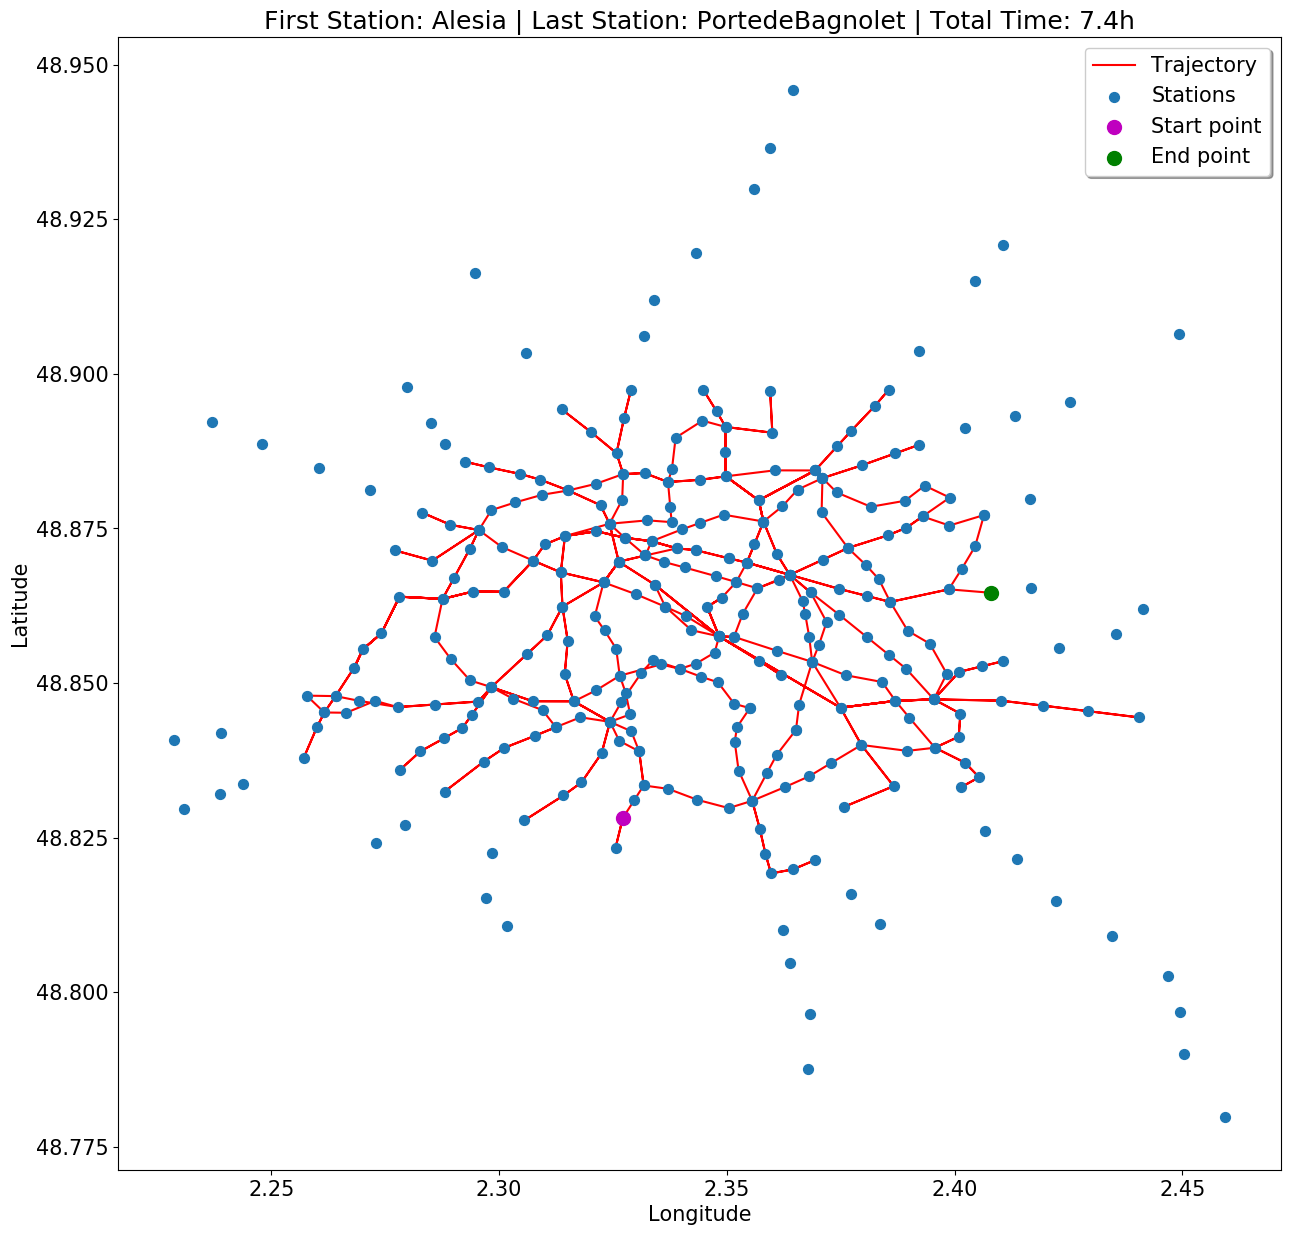

In [63]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

#Changing the font size of the graphic
plt.rcParams.update({'font.size': 15})

#Latitides and Longitudes of 
lat, lon = ver['lat'], ver['lon']

fig, ax = plt.subplots(figsize=(15, 15), dpi=100) 

i = 0
x = []
y = []

#Starting point
x0 = float(ver['lon'][xs])
y0 = float(ver['lat'][xs])

for n in p1:
    if len(ver['lat'].loc[(ver['id'] == n)]) != 0: 
        x.append(float(ver['lon'][n])) 
        y.append(float(ver['lat'][n])) 
    i = i+1
     
x.append(float(ver['lon'][pt2[-1]])) 
y.append(float(ver['lat'][pt2[-1]]))

#Ending Point
xf = float(ver['lon'][pt2[-1]])
yf = float(ver['lat'][pt2[-1]])

plt.plot(x, y,'r', zorder=1)
plt.scatter(lon, lat,s=50,zorder=2)

#Starting point
plt.scatter(x0, y0, c =  'm', s=100,zorder=3)
#Ending point
plt.scatter(xf, yf, c =  'g', s=100,zorder=3)

#
ax.legend(('Trajectory', 'Stations','Start point', 'End point'), loc='upper right', shadow=True)
plt.title('First Station: ' + str(ver['Station'][pt1[0]]) + ' | ' 
          + 'Last Station: ' + str(ver['Station'][pt2[-1]])  + ' | ' 
          + 'Total Time: ' + str(total)+'h')
plt.axis(aspect='equal')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()
    

### The shortest time found was 7h and 24 minutes as can be observed in the Figure 1, having Alesia as the initial station and Porte de Bagnolet as end station. 

### It’s important to point out that, as an average, total time to go through all the intramural stations is 8h to 9h, which is an acceptable result since the goal of the problem is to visit all the intramural stations in one day.